In [133]:
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import words
import torch
from Models.CNN import CNN,Model_training,load_data,plot_metrics,evaluate_cnn_model
import re
import language_tool_python
from collections import Counter
from PIL import Image
from textblob import TextBlob
import cufflinks as cf
import plotly.express as px
import plotly.figure_factory as ff
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
# import torch
# from transformers import PegasusForConditionalGeneration, PegasusTokenizer
# from transformers import T5Tokenizer, T5ForConditionalGeneration
# from transformers import GPT2Tokenizer, GPT2LMHeadModel
from Prog.ModelEvaluator import ModelEvaluator
from Models.HARDVOTING_multi import HardVotingClassifier
from Models.XGBoost import XGBoostClassifier
from Models.KNN import KNNClassifier 
from imblearn.over_sampling import SMOTE
from Models.SVM import SVMClassifier
from Models.LSTM import LSTMClassifier
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud,STOPWORDS
from nltk.corpus import stopwords
from plotly import graph_objs as go
from collections import defaultdict
import pandas as pd
from plotly import tools
from plotly.offline import iplot
from palettable.colorbrewer.qualitative import Pastel1_7




In [46]:
from Preprocess.data_cleaning import DataCleaning
from Preprocess.data_visualisation import Data_visualisation
from Embeddings.Bert_Embeddings import BertEmbedding
from Embeddings.Deberta_embed import DebertaEmbedding
from Embeddings.Roberta_Embeddings import RobertaEmbedding

### Read data

In [23]:
df = pd.read_csv('C:/Users/iyadh/Desktop/hate_speech/Data/Ethos_Dataset_Multi_Label.csv', sep=';')

In [24]:
df.columns

Index(['comment', 'violence', 'directed_vs_generalized', 'gender', 'race',
       'national_origin', 'disability', 'religion', 'sexual_orientation'],
      dtype='object')

In [25]:
df.head(4)

,comment,violence,directed_vs_generalized,gender,race,national_origin,disability,religion,sexual_orientation
0,You should know women's sports are a joke,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.0
1,You look like Sloth with deeper Down’s syndrome,0.000000,0.833333,0.000000,0.000000,0.000000,1.0,0.0,0.0
2,You look like Russian and speak like Indian. B...,1.000000,0.500000,0.142857,0.142857,0.714286,0.0,0.0,0.0
3,"Women deserve to be abused, I guess.",0.666667,0.166667,1.000000,0.000000,0.000000,0.0,0.0,0.0


In [26]:
df.isnull().sum()

comment                    0
violence                   0
directed_vs_generalized    0
gender                     0
race                       0
national_origin            0
disability                 0
religion                   0
sexual_orientation         0
dtype: int64

In [27]:
df.shape

(433, 9)

### Preprocess data

In [28]:
# Create new DataFrame
df_fin = df[['comment']].copy()
cols = df.columns[1:]

# Get the column name with the maximum value
df_fin['class'] = df[cols].idxmax(axis=1)

In [29]:
df_fin.head(4)

,comment,class
0,You should know women's sports are a joke,gender
1,You look like Sloth with deeper Down’s syndrome,disability
2,You look like Russian and speak like Indian. B...,violence
3,"Women deserve to be abused, I guess.",gender


In [30]:
df_fin['class'].value_counts()

class
violence                   82
directed_vs_generalized    61
religion                   58
race                       58
gender                     48
sexual_orientation         45
national_origin            44
disability                 37
Name: count, dtype: int64

In [31]:
df_fin.isnull().sum()

comment    0
class      0
dtype: int64

## 2. Data Perprocessing

In [33]:
df_fin['cleaned_comment'] = df['comment'].apply(DataCleaning.preprocess_text)

In [34]:
df_fin

,comment,class,cleaned_comment
0,You should know women's sports are a joke,gender,You should know women's sports are a joke
1,You look like Sloth with deeper Down’s syndrome,disability,You look like sloth with deeper downs syndrome
2,You look like Russian and speak like Indian. B...,violence,You look like Russian and speak like Indian bo...
3,"Women deserve to be abused, I guess.",gender,Women deserve to be abused I guess
4,Women are made for making babies and cooking d...,gender,Women are made for making babies and cooking d...
...,...,...,...
428,All people are fucked up because of these quee...,gender,All people are fucked up because of this queer...
429,Actually THIS WEIRD PEOPLE are HARMFUL! They n...,directed_vs_generalized,Actually this weird people are harmful they ne...
430,ABU DA BI ABA DU BA BA HAMUD! See? I’m an arab...,religion,Abu the bi ABA Du ba Hamid see I am an Arab pr...
431,a homo? so you fuck your brother instead of yo...,sexual_orientation,A homo so you fuck your brother instead of you...


# 4. Data augmentation
##### Since we dont have cuda were going to run in colab and u can find the notebooks in folder colab notebooks


# 4. Data visulaisation

# 5. Data modeling

In [37]:
# Encode target variable
le = LabelEncoder()
df_fin['class'] = le.fit_transform(df_fin['class'])

In [43]:
# Create a mapping dictionary
class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
for class_name, encoded_value in class_mapping.items():
    print(f"Class: {class_name}, Encoded Value: {encoded_value}")

Class: directed_vs_generalized, Encoded Value: 0
Class: disability, Encoded Value: 1
Class: gender, Encoded Value: 2
Class: national_origin, Encoded Value: 3
Class: race, Encoded Value: 4
Class: religion, Encoded Value: 5
Class: sexual_orientation, Encoded Value: 6
Class: violence, Encoded Value: 7


## We'll start with bert embeddings

In [44]:
df = df_fin[['cleaned_comment', 'class']]

In [47]:
traindata,testdata=train_test_split(df,test_size=0.2,random_state=42)
print('Data shapes :',traindata.shape,testdata.shape)

Data shapes : (346, 2) (87, 2)


In [48]:
train_comments = traindata['cleaned_comment'].values.tolist()
train_labels = traindata['class'].values.tolist()
test_comments = testdata['cleaned_comment'].values.tolist()
test_labels = testdata['class'].values.tolist()

train_comments, val_comments, train_labels, val_labels = train_test_split(train_comments, train_labels,
                                                                            test_size=0.1,random_state=42,stratify=train_labels)

In [49]:
print('Comments len :')
print('----')
print('train_comments',len(train_comments))
print('test_comments',len(test_comments))
print('valid_comments',len(val_comments))
print('----')

Comments len :
----
train_comments 311
test_comments 87
valid_comments 35
----


In [50]:
# Instance of bert embeddings
BertEmbed=BertEmbedding(train_comments, test_comments, val_comments)

In [51]:
tokenizer, train_embeddings, val_embeddings, test_embeddings =  BertEmbed.generate_bert_embeddings()

In [52]:
#Create train dataframe
dfinter = []
for emb, label in zip(train_embeddings, train_labels):
    dfinter.append({'comment_embedding': emb, 'label': label})
traindata = pd.DataFrame(dfinter)
print(traindata.shape)
traindata.head(4)

(311, 2)


,comment_embedding,label
0,"[0.15560097, 0.04676331, 0.4400749, -0.430222,...",7
1,"[0.2567176, 0.88707924, -0.20989671, -0.201974...",2
2,"[-0.1106464, 0.095631294, -0.63025504, 0.19453...",2
3,"[-0.08840955, 0.14026135, -0.13739222, 0.06525...",7


In [53]:
#Create test dataframe
dfinter = []
for emb, label in zip(test_embeddings, test_labels):
    dfinter.append({'comment_embedding': emb, 'label': label})
testdata = pd.DataFrame(dfinter)
print(testdata.shape)
testdata.head(4)

(87, 2)


,comment_embedding,label
0,"[0.3450382, 0.24087611, 0.07176296, -0.1860140...",2
1,"[0.22369659, 0.5763439, -0.56303674, -0.148336...",7
2,"[-0.06582112, 0.5218068, -0.15417518, 0.113241...",3
3,"[0.23757221, 0.44014308, -0.16812348, 0.149735...",0


In [54]:
#Create val dataframe
dfinter = []
for emb, label in zip(val_embeddings, val_labels):
    dfinter.append({'comment_embedding': emb, 'label': label})
valdata = pd.DataFrame(dfinter)
print(valdata.shape)
valdata.head(4)

(35, 2)


,comment_embedding,label
0,"[-0.18189669, 0.41405547, 0.42645758, -0.43729...",2
1,"[0.055010673, 0.096587606, -0.26337188, 0.2176...",7
2,"[0.41052425, 0.014450371, 0.2141315, 0.2332945...",0
3,"[0.51359546, 0.40643233, -0.1433517, -0.240119...",5


### CNN

In [60]:
#Get data
train_data, val_data, test_data = load_data(traindata, valdata, testdata)

cnn_model = CNN(768,8)

# Entraînement du modèle
trainer = Model_training(cnn_model, train_data, val_data,epochs=20)
train_losses, val_losses, train_accuracies, val_accuracies = trainer.train()

Epoch [20/20], Train Loss: 0.8429, Val Loss: 1.0386, Train Acc: 0.7492, Val Acc: 0.6000


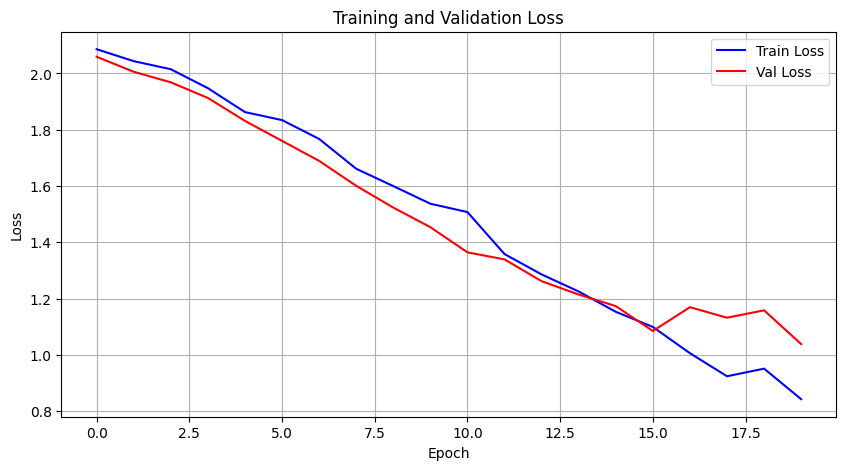

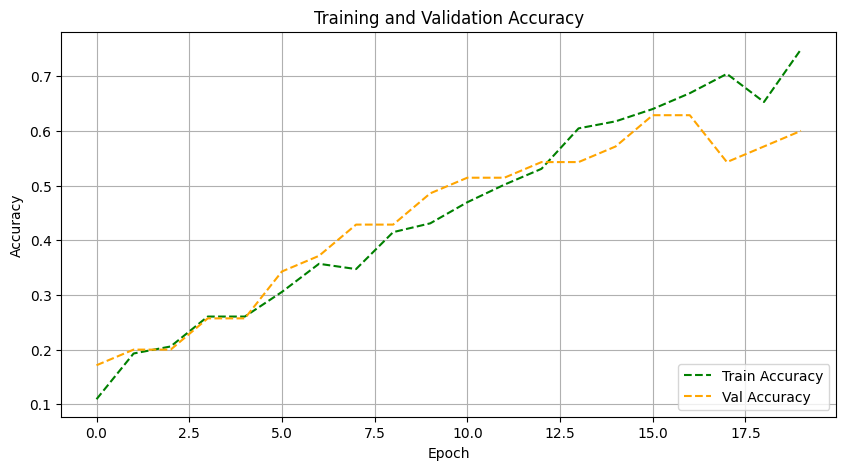

In [61]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

Accuracy 0.5747, Precision: 0.6449, Recall: 0.5523, F1-score: 0.5525

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.56      0.60        16
           1       0.75      0.33      0.46         9
           2       1.00      0.56      0.71         9
           3       0.50      0.17      0.25         6
           4       0.70      0.54      0.61        13
           5       0.50      0.83      0.62         6
           6       0.67      0.57      0.62        14
           7       0.40      0.86      0.55        14

    accuracy                           0.57        87
   macro avg       0.64      0.55      0.55        87
weighted avg       0.64      0.57      0.57        87



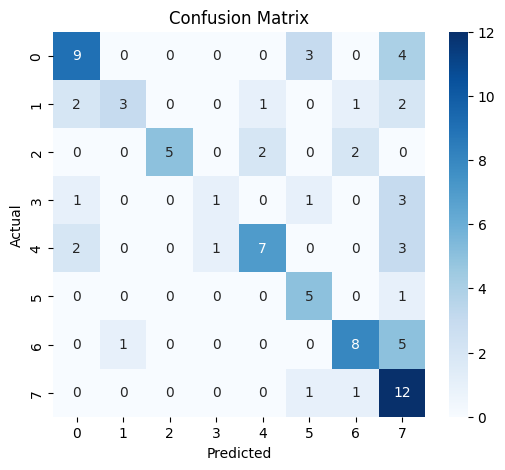

In [62]:
evaluate_cnn_model(cnn_model, test_data)

## SVM

In [101]:
X_train = np.array(traindata['comment_embedding'].tolist())
y_train = np.array(traindata['label'])

X_val = np.array(valdata['comment_embedding'].tolist())
y_val = np.array(valdata['label'])

X_test = np.array(testdata['comment_embedding'].tolist())
y_test = np.array(testdata['label'])

In [102]:

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [103]:
# Instanciation de l'objet SVMClassifier
svm_model = SVMClassifier(kernel='linear')

In [104]:
# Train SVM model
svm_model.train_model(X_train_resampled,y_train_resampled)

# Predict on test set
y_pred = svm_model.predict_data(X_test)


In [105]:
# Vérifier les performances après l'entraînement
train_accuracy = svm_model.model.score(X_train_resampled, y_train_resampled)
val_accuracy = svm_model.model.score(X_val, y_val)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")


Train Accuracy: 1.0000
Validation Accuracy: 0.6000


Accuracy: 0.5632, Precision: 0.5650, Recall: 0.5448, F1-score: 0.5404

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.81      0.68        16
           1       0.75      0.67      0.71         9
           2       0.67      0.67      0.67         9
           3       0.33      0.33      0.33         6
           4       0.50      0.31      0.38        13
           5       0.33      0.50      0.40         6
           6       0.88      0.50      0.64        14
           7       0.47      0.57      0.52        14

    accuracy                           0.56        87
   macro avg       0.56      0.54      0.54        87
weighted avg       0.59      0.56      0.56        87



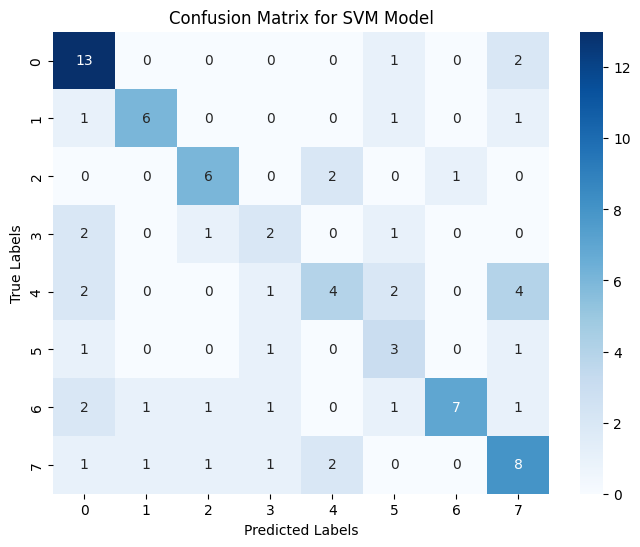

In [106]:
svm_model.evaluate_svm_model(X_test, y_test)

### KNN

In [119]:
knn_classifier = KNNClassifier(n_neighbors=3)

In [120]:
# Train KNN model
knn_classifier.train_model(X_train_resampled,y_train_resampled)


Accuracy: 0.2989, Precision: 0.3115, Recall: 0.3018, F1-score: 0.2714

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.44      0.41        16
           1       0.27      0.67      0.39         9
           2       0.33      0.22      0.27         9
           3       0.11      0.17      0.13         6
           4       0.30      0.23      0.26        13
           5       0.22      0.33      0.27         6
           6       0.36      0.29      0.32        14
           7       0.50      0.07      0.12        14

    accuracy                           0.30        87
   macro avg       0.31      0.30      0.27        87
weighted avg       0.34      0.30      0.28        87



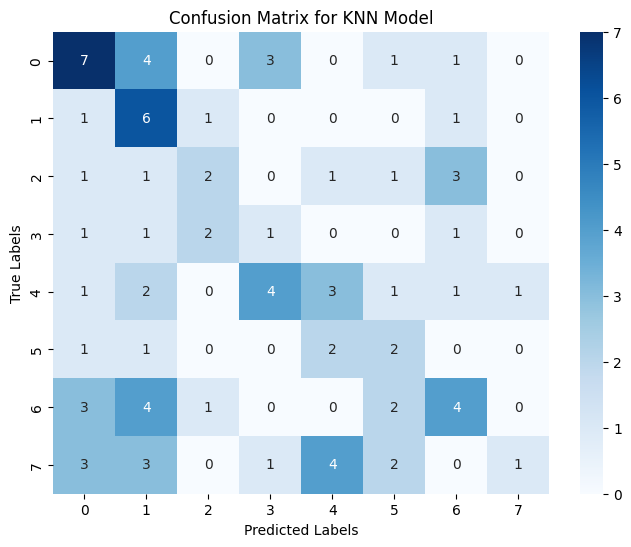

In [132]:
knn_classifier.evaluate_knn_model(X_test, y_test)

### Neural network

In [129]:
from Models.Neural_net import NeuralNetworkClassifier 

Accuracy: 0.6092, Precision: 0.6119, Recall: 0.5938, F1-score: 0.5934

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.81      0.76        16
           1       0.75      0.67      0.71         9
           2       0.60      0.67      0.63         9
           3       0.50      0.50      0.50         6
           4       0.67      0.46      0.55        13
           5       0.43      0.50      0.46         6
           6       0.78      0.50      0.61        14
           7       0.45      0.64      0.53        14

    accuracy                           0.61        87
   macro avg       0.61      0.59      0.59        87
weighted avg       0.63      0.61      0.61        87



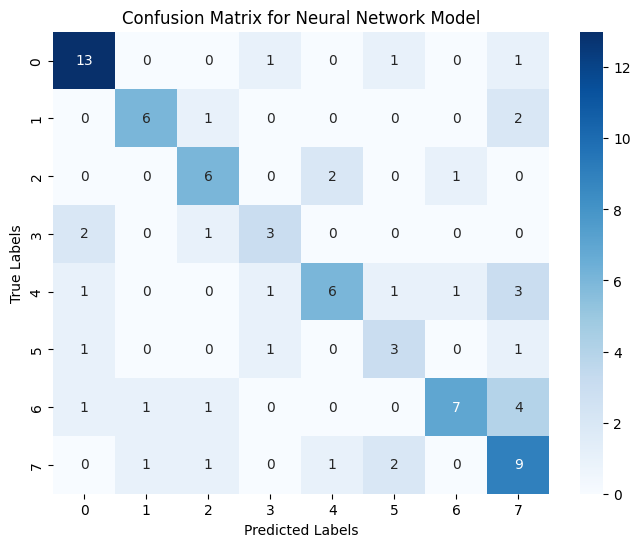

In [131]:
nn_classifier = NeuralNetworkClassifier(hidden_layer_sizes=(100,), max_iter=200, activation='relu')

# Train the model
nn_classifier.train_model(X_train_resampled, y_train_resampled)

# Evaluate the model
nn_classifier.evaluate_nn_model(X_test, y_test)

### Hard Voting

In [137]:
# Initialize the HardVotingClassifier with all five models
hard_voting_model = HardVotingClassifier(
    svm_model=svm_model,
    knn_model=knn_classifier,
    cnn_model=cnn_model,
    nn_model=nn_classifier
)

# Convert validation data to PyTorch tensor for CNN
val_inputs_tensor = torch.tensor(X_val, dtype=torch.float32)

# Perform predictions using the hard voting model
y_pred = hard_voting_model.predict(X_val, val_inputs_tensor)

# Evaluate the model performance (e.g., accuracy)
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy of Hard Voting Classifier: {accuracy:.4f}')


Accuracy of Hard Voting Classifier: 0.6857


Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.60      0.55         5
           1       1.00      0.67      0.80         3
           2       0.75      0.75      0.75         4
           3       0.67      0.50      0.57         4
           4       0.50      0.50      0.50         4
           5       0.67      0.80      0.73         5
           6       1.00      1.00      1.00         3
           7       0.71      0.71      0.71         7

    accuracy                           0.69        35
   macro avg       0.72      0.69      0.70        35
weighted avg       0.70      0.69      0.69        35


Confusion Matrix:


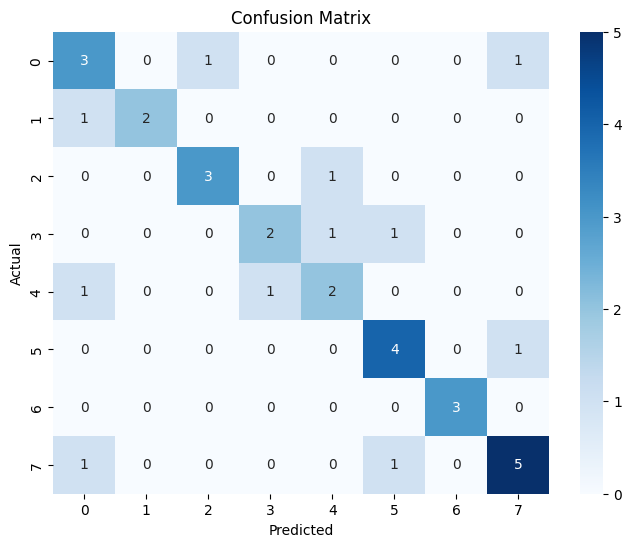

In [138]:
# Evaluate the model with the provided validation data
hard_voting_model.evaluate(X_val, val_inputs_tensor, y_val)

In [144]:
import pandas as pd
from sklearn.metrics import accuracy_score
import torch

class ModelEvaluator:
    def __init__(self, models, model_instances, X_val, val_inputs_tensor, y_val):
        self.models = models
        self.model_instances = model_instances
        self.X_val = X_val
        self.val_inputs_tensor = val_inputs_tensor
        self.y_val = y_val
        self.accuracies = {}
    
    def get_accuracy(self, model):
        model_instance = self.model_instances.get(model)
        
        if model == 'hard_voting':
            y_pred = model_instance.predict(self.X_val, self.val_inputs_tensor)
        elif model == 'svm':
            y_pred = model_instance.predict_data(self.X_val)
        elif model == 'knn':
            y_pred = model_instance.predict_data(self.X_val)
        elif model == 'nn_classifier':  # Neural Network Classifier
            y_pred = model_instance.predict_data(self.X_val)
        elif model == 'cnn':
            with torch.no_grad():
                cnn_preds_raw = model_instance(self.val_inputs_tensor)
                y_pred = torch.argmax(torch.softmax(cnn_preds_raw, dim=1), dim=1).cpu().numpy()
        else:
            raise ValueError(f"Model '{model}' not recognized. Please check the model name.")
        
        return accuracy_score(self.y_val, y_pred)
    
    def evaluate_models(self):
        for model in self.models:
            self.accuracies[model] = self.get_accuracy(model)
        
    def display_results(self):
        accuracy_df = pd.DataFrame(list(self.accuracies.items()), columns=['Model', 'Accuracy'])
        print(accuracy_df)
        return accuracy_df


# List of models
models = ['hard_voting', 'svm', 'knn', 'cnn', 'nn_classifier']

# Model instances
the_models = {
    'hard_voting': hard_voting_model,
    'svm': svm_model,
    'knn': knn_classifier,
    'cnn': cnn_model,
    'nn_classifier': nn_classifier
}

# Instantiate and evaluate
model_evaluator = ModelEvaluator(models, the_models, X_val, val_inputs_tensor, y_val)
model_evaluator.evaluate_models()
print('---Accuracy with bert embeddings---')
accuracy_df = model_evaluator.display_results()


---Accuracy with bert embeddings---
           Model  Accuracy
0    hard_voting  0.685714
1            svm  0.600000
2            knn  0.400000
3            cnn  0.600000
4  nn_classifier  0.714286
